In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import requests
import cv2
from PIL import Image, ImageChops
import urllib
import time
import glob
import random
print(tf.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0-beta1


In [2]:
IMAGE_SIZE = 160

In [3]:
def load_img_to_np_array(image_path, show_image = False):
    raw_image = load_img(image_path)
    resized_image = raw_image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image_arr = img_to_array(resized_image)
    imaimage_arrge = np.array(image_arr, dtype=float)

    if (show_image):
        plt.figure()
        plt.imshow(resized_image)
        
#     print(resized_image)
#     print(image_arr.shape)
    return resized_image, image_arr

def convert_rgb2lab(image_arr):
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    X = X.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
    Y = Y.reshape(IMAGE_SIZE, IMAGE_SIZE, 2)
    
#     print(X.shape)
#     print(Y.shape)
    
#     print(Y.min())
#     print(Y.max())
    
    return X, Y

def show_images(original, model_prediction, grayscale):
    
    plt.figure(figsize=(20,20))

    plt.subplot(3,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)
    plt.xlabel("original")

    plt.subplot(3,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayscale, cmap =plt.cm.gray)
    plt.xlabel("grayscale")

    plt.subplot(3,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_prediction)
    plt.xlabel("rgb prediction")

    plt.show()
    
def predict(m_model, original_image, inputX):
    output = m_model.predict(inputX)
    output *= 128
    # Output colorizations
    cur = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    cur[:,:,0] = inputX[0][:,:,0]
    cur[:,:,1:] = output[0]
    
    print(inputX.shape)
    print(output.shape)

    predicted_image = lab2rgb(cur)
    show_images(original_image, predicted_image, rgb2gray(predicted_image))
    
def load_and_preprocess_images(images_path, show_images=False):
    images_arr = []
    for i in range(len(images_path)):
        img, arr = load_img_to_np_array(images_path[i], show_image=show_images)
        
        if not is_greyscale(img):
            images_arr.append((img, arr))
            
    print(str(len(images_arr)) + " images were loaded successfully")
    return np.array(images_arr)

def convert_all_images_rgb2lab(images_arr):
    input_x = []
    output_y = []
    
    for image_arr in images_arr:
        in_x, out_y = convert_rgb2lab(image_arr[1])
        input_x.append(in_x)
        output_y.append(out_y)
    
    return np.array(input_x), np.array(output_y)

def is_greyscale(im):
    """
    Check if image is monochrome (1 channel or 3 identical channels)
    """
    if im.mode not in ("L", "RGB"):
        raise ValueError("Unsuported image mode")

    if im.mode == "RGB":
        rgb = im.split()
        if ImageChops.difference(rgb[0],rgb[1]).getextrema()[1]!=0: 
            return False
        if ImageChops.difference(rgb[0],rgb[2]).getextrema()[1]!=0: 
            return False
    return True


In [4]:
NUM_OF_IMAGES = 1
EPOCHS = 100

In [5]:
train_images = list(glob.glob('train/*'))
train_images = [str(path) for path in train_images]
# random.shuffle(train_images)

print(len(train_images))
# train_images = train_images[:NUM_OF_IMAGES]
train_images = train_images[6:6 + NUM_OF_IMAGES]
print(len(train_images))
images_and_arrs = load_and_preprocess_images(train_images)

673
1
1 images were loaded successfully


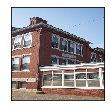

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    if (i < len(images_and_arrs)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_and_arrs[i][0])
plt.show()

In [21]:
input_x, output_y = convert_all_images_rgb2lab(images_and_arrs)

print("input_x shape = " + str(input_x.shape))
print("output_y shape = " + str(output_y.shape))

for out_y in output_y:
    print(out_y.min())
    print(out_y.max())
    


input_x shape = (1, 160, 160, 1)
output_y shape = (1, 160, 160, 2)
-0.2341527866450463
0.24043088930247902


# Create the base model from the pre-trained convnets

In [22]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)


# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [33]:

IMG_BATCH = tf.convert_to_tensor([32, 160, 160, 3], dtype=tf.int32)
print(IMG_BATCH)

tf.Tensor(
[[ 32]
 [160]
 [160]
 [ 32]], shape=(4, 1), dtype=int32)


In [28]:
feature_batch = base_model(IMG_BATCH)


InvalidArgumentError: The first dimension of paddings must be the rank of inputs[4,2] [4] [Op:Pad]

In [35]:
# Building the neural network
model = keras.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, input_shape=(None, None, 1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, None, None, 32)   

In [63]:
history = model.fit(x=input_x, 
          y=output_y,
          batch_size=1,
          epochs=EPOCHS)

Train on 1 samples
Epoch 1/100
1/1 [==============================] - 0s 297ms/sample - loss: 0.0035 - accuracy: 0.7327
Epoch 2/100
1/1 [==============================] - 0s 43ms/sample - loss: 0.0029 - accuracy: 0.7444
Epoch 3/100
1/1 [==============================] - 0s 49ms/sample - loss: 0.0029 - accuracy: 0.7448
Epoch 4/100
1/1 [==============================] - 0s 46ms/sample - loss: 0.0024 - accuracy: 0.7414
Epoch 5/100
1/1 [==============================] - 0s 45ms/sample - loss: 0.0029 - accuracy: 0.7565
Epoch 6/100
1/1 [==============================] - 0s 47ms/sample - loss: 0.0025 - accuracy: 0.7388
Epoch 7/100
1/1 [==============================] - 0s 50ms/sample - loss: 0.0033 - accuracy: 0.7566
Epoch 8/100
1/1 [==============================] - 0s 43ms/sample - loss: 0.0021 - accuracy: 0.7420
Epoch 9/100
1/1 [==============================] - 0s 53ms/sample - loss: 0.0018 - accuracy: 0.7535
Epoch 10/100
1/1 [==============================] - 0s 49ms/sample - loss: 0.001

1/1 [==============================] - 0s 79ms/sample - loss: 0.0010 - accuracy: 0.8144
Epoch 83/100
1/1 [==============================] - 0s 71ms/sample - loss: 0.0012 - accuracy: 0.8272
Epoch 84/100
1/1 [==============================] - 0s 66ms/sample - loss: 9.2649e-04 - accuracy: 0.8225
Epoch 85/100
1/1 [==============================] - 0s 62ms/sample - loss: 0.0010 - accuracy: 0.8255
Epoch 86/100
1/1 [==============================] - 0s 62ms/sample - loss: 9.8245e-04 - accuracy: 0.8270
Epoch 87/100
1/1 [==============================] - 0s 57ms/sample - loss: 0.0012 - accuracy: 0.8152
Epoch 88/100
1/1 [==============================] - 0s 61ms/sample - loss: 0.0010 - accuracy: 0.8305
Epoch 89/100
1/1 [==============================] - 0s 51ms/sample - loss: 0.0011 - accuracy: 0.8186
Epoch 90/100
1/1 [==============================] - 0s 57ms/sample - loss: 8.7722e-04 - accuracy: 0.8361
Epoch 91/100
1/1 [==============================] - 0s 55ms/sample - loss: 9.7712e-04 - accu

In [73]:
num_of_photos = str(len(train_images))
num_of_epochs = str(EPOCHS)

model_name = 'Colorize-V4-' + num_of_photos + 'photos-'+ num_of_epochs + 'epochs-' + str(IMAGE_SIZE) + "x" + str(IMAGE_SIZE)
MODEL_PATH = 'models/'+ model_name +'.h5'

i = 2
while(os.path.isfile(MODEL_PATH)):
    model_name = model_name + '-' + str(i)
    MODEL_PATH = 'models/'+ model_name +'.h5'
    
    
print('model will be saved as: ' + str(MODEL_PATH))

model will be saved as: models/Colorize-V4-1photos-100epochs-160x160.h5


In [65]:
model.save(MODEL_PATH)

In [66]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model(MODEL_PATH)
new_model.summary()

# Recreate the exact same model, including weights and optimizer.
first_model = keras.models.load_model('models/Colorize-V2.h5')
first_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, None, None, 32)   

(1, 160, 160, 1)
(1, 160, 160, 2)


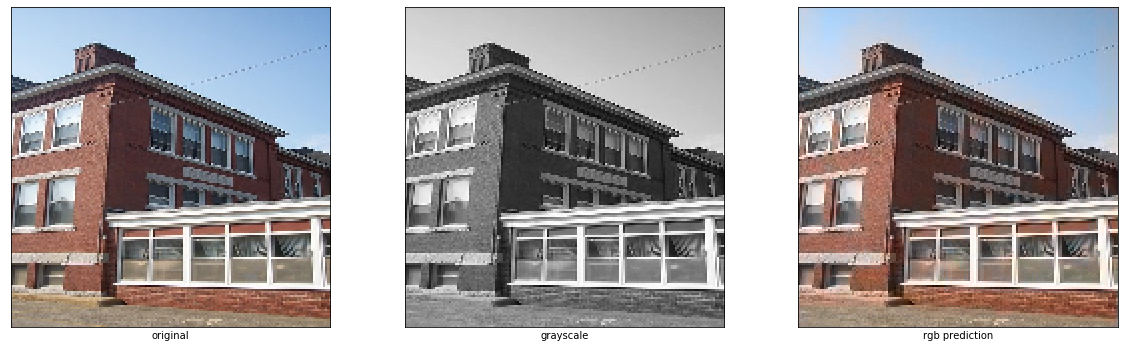

(1, 160, 160, 1)
(1, 160, 160, 2)


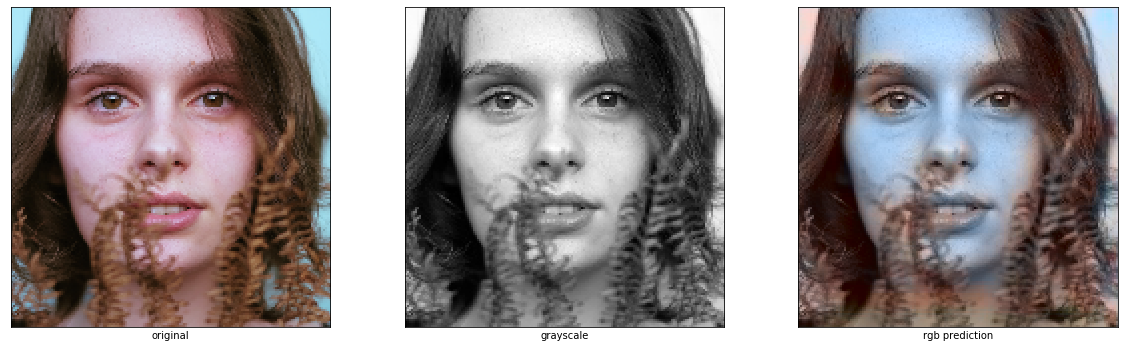

(1, 160, 160, 1)
(1, 160, 160, 2)


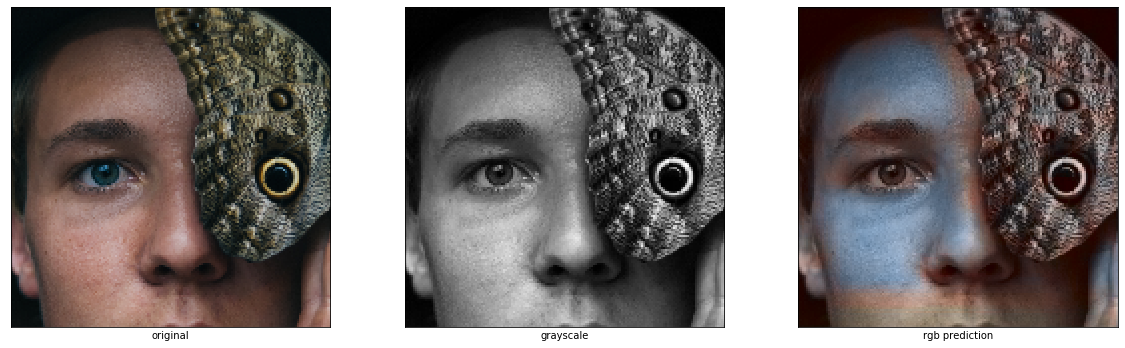

In [67]:
for ind in range(len(images_and_arrs)):
    test_image, test_arr = images_and_arrs[ind]
    test_x, test_y = convert_rgb2lab(test_arr)
    predict(new_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("woman.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(new_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("man.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(new_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

(1, 160, 160, 1)
(1, 160, 160, 2)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 12 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


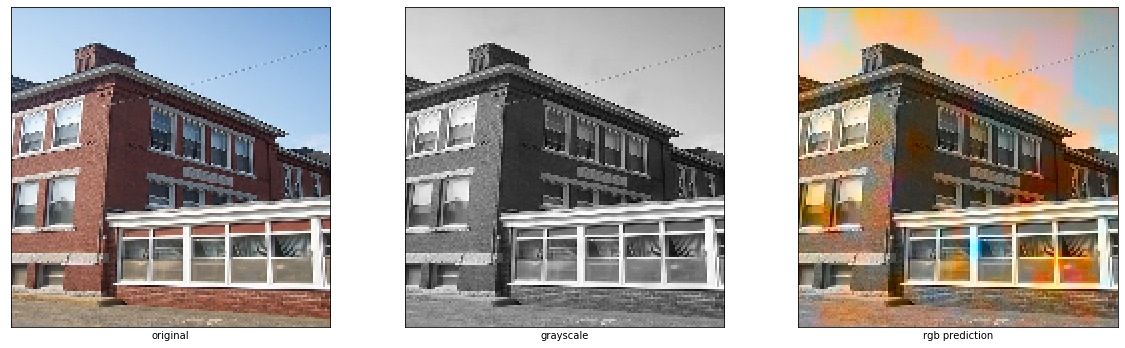

(1, 160, 160, 1)
(1, 160, 160, 2)


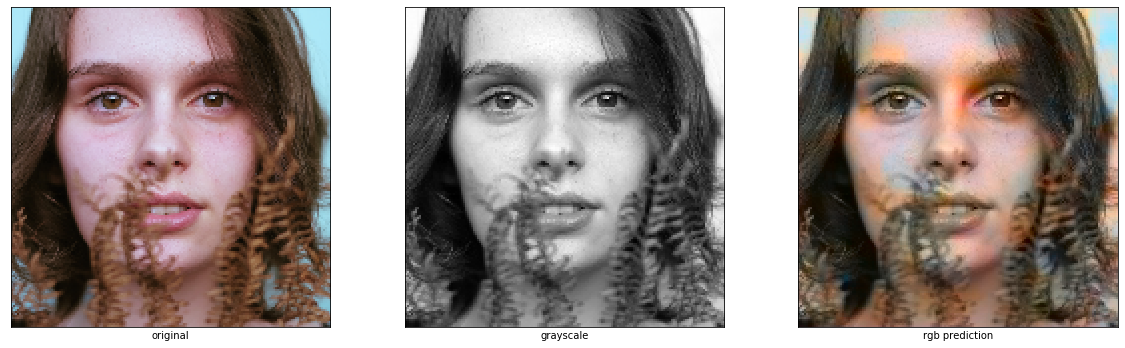

(1, 160, 160, 1)
(1, 160, 160, 2)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


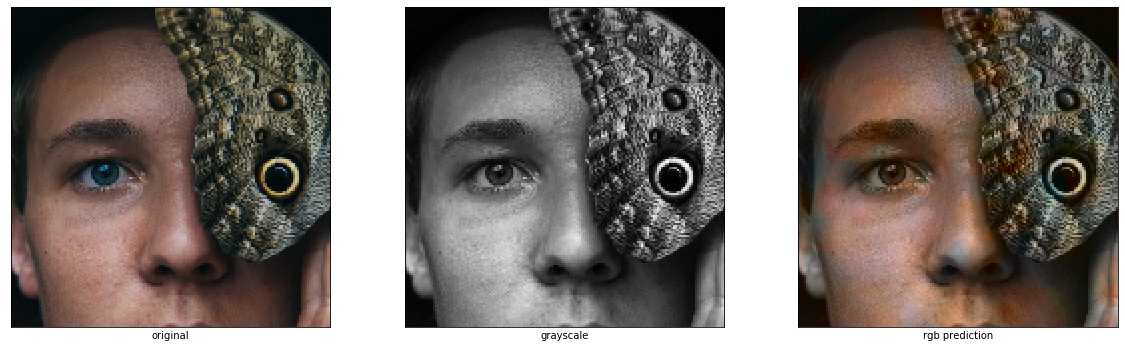

In [69]:
for ind in range(len(images_and_arrs)):
    test_image, test_arr = images_and_arrs[ind]
    test_x, test_y = convert_rgb2lab(test_arr)
    predict(first_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("woman.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(first_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("man.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(first_model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))